In [28]:
import pathlib
import json
from pydantic import BaseModel, create_model
from dataprep.eda import plot, plot_correlation, plot_diff, plot_missing
from dataprep.clean import clean_df, clean_duplication, clean_headers, clean_lat_long
import pandas as pd
import numpy as np
import typing as t
import sys
import os
# from sqlmodel import SQLModel, create_engine,Field


In [6]:
data = pathlib.Path().cwd().parent / "data"
routes_path = data /"Routen"
congestion_path = data /"Staudaten"

In [7]:
route_files = [f for f in routes_path.glob("*.csv")]
congestion_files = [f for f in congestion_path.glob("*.json")]

In [8]:
routes = [pd.read_csv(csv) for csv in route_files]


In [5]:
# plot(routes[0])

In [6]:
# city1 = pd.get_dummies(routes[0].city1,prefix="city_1_")
# city2 = pd.get_dummies(routes[0].city2,prefix="city_2_")
# with_dummies = routes[0].merge(city1,right_index=True,left_index=True).merge(city2,right_index=True,left_index=True)
# plot_correlation(with_dummies)


In [9]:
congestions = []
for f in congestion_files:
    with open(f, "rb") as file_:
        js = json.load(file_)
        if "TRAFFIC_ITEMS" in js.keys():
            for traffic_item in js.get("TRAFFIC_ITEMS").get("TRAFFIC_ITEM"):
                congestions.append(traffic_item)


In [21]:
df=pd.json_normalize(congestions)
df.columns

Index(['TRAFFIC_ITEM_ID', 'ORIGINAL_TRAFFIC_ITEM_ID',
       'TRAFFIC_ITEM_STATUS_SHORT_DESC', 'TRAFFIC_ITEM_TYPE_DESC',
       'START_TIME', 'END_TIME', 'ENTRY_TIME', 'VERIFIED',
       'TRAFFIC_ITEM_DESCRIPTION', 'mid', 'PRODUCT', 'CRITICALITY.ID',
       'CRITICALITY.DESCRIPTION', 'ABBREVIATION.SHORT_DESC',
       'ABBREVIATION.DESCRIPTION', 'RDS-TMC_LOCATIONS.RDS-TMC',
       'LOCATION.DEFINED.ORIGIN.ROADWAY.DESCRIPTION',
       'LOCATION.DEFINED.ORIGIN.ROADWAY.ID',
       'LOCATION.DEFINED.ORIGIN.POINT.DESCRIPTION',
       'LOCATION.DEFINED.ORIGIN.POINT.ID',
       'LOCATION.DEFINED.ORIGIN.DIRECTION.DESCRIPTION',
       'LOCATION.DEFINED.ORIGIN.DIRECTION.ID',
       'LOCATION.DEFINED.ORIGIN.PROXIMITY.ID',
       'LOCATION.DEFINED.ORIGIN.PROXIMITY.DESCRIPTION',
       'LOCATION.DEFINED.TO.ROADWAY.DESCRIPTION',
       'LOCATION.DEFINED.TO.ROADWAY.ID',
       'LOCATION.DEFINED.TO.POINT.DESCRIPTION', 'LOCATION.DEFINED.TO.POINT.ID',
       'LOCATION.DEFINED.TO.DIRECTION.DESCRIPTION',
 

In [22]:
from shapely.geometry import LineString
def clean_congestion_data(df):
    df = df.pipe(clean_headers,report=False).rename(columns={"location_geoloc_origin_latitude":"from_latitude","location_geoloc_origin_longitude":"from_longitude"})
    df.traffic_item_description=pd.json_normalize(df.traffic_item_description.apply(lambda x: x[0]))["value"]
    df = pd.json_normalize(df.location_geoloc_to.apply(lambda x: x[0])).rename(columns={"LATITUDE":"to_latitude","LONGITUDE":"to_longitude"}).merge(df,left_index=True,right_index=True).drop(columns=["location_geoloc_to"])    
    return df[['start_time', 'end_time', 'entry_time', 'verified','from_latitude','from_longitude','to_latitude', 'to_longitude','location_length','traffic_item_detail_incident_congestion_incident_congestion_type_desc',
       'traffic_item_detail_incident_congestion_incident_congestion_factor',"traffic_item_description",'traffic_item_detail_road_closed',
       'traffic_item_detail_incident_response_vehicles','criticality_description','abbreviation_description']]
        
df = df.pipe(clean_congestion_data)
df

start_time             end_time           entry_time  verified  \
0     08/21/2021 07:09:50  08/21/2021 07:27:33  08/21/2021 07:10:19      True   
1     08/21/2021 07:09:19  08/21/2021 07:28:19  08/21/2021 07:18:19      True   
2     08/21/2021 07:15:34  08/21/2021 07:28:19  08/21/2021 07:18:19      True   
3     08/21/2021 06:37:49  08/21/2021 07:28:19  08/21/2021 07:18:19      True   
4     08/21/2021 07:09:48  08/21/2021 07:28:19  08/21/2021 07:18:19      True   
...                   ...                  ...                  ...       ...   
4610  08/26/2021 04:01:44  08/26/2021 04:17:32  08/26/2021 04:07:37      True   
4611  08/26/2021 04:06:49  08/26/2021 04:17:34  08/26/2021 04:07:37      True   
4612  08/26/2021 03:35:04  08/26/2021 04:17:34  08/26/2021 04:03:07      True   
4613  08/26/2021 04:07:22  08/26/2021 04:17:46  08/26/2021 04:07:47      True   
4614  08/26/2021 04:01:49  08/26/2021 04:17:34  08/26/2021 04:07:37      True   

      from_latitude  from_longitude  to_latitude  to_longitude  \
0          47.42830         8.50571     47.42699       8.49887   
1          48.95784        11.42564     48.95768      11.42578   
2          52.67427        13.39804     52.67477      13.39724   
3          51.08336        13.68978     51.08663      13.69144   
4          54.31536        10.10986     54.31547      10.11036   
...             ...             ...          ...           ...   
4610       52.33467        14.90301     52.33464      14.90345   
4611       47.60896        12.19921     47.60950      12.19974   
4612       52.46169        13.42866     52.46178      13.42939   
4613       47.60415        12.19154     47.60278      12.18777   
4614       52.59214        13.28737     52.58966      13.28909   

      location_length  \
0             0.33416   
1             0.01928   
2             0.05256   
3             0.23743   
4             0.02164   
...               ...   
4610          0.01890   
4611          0.04487   
4612          0.03155   
4613          0.20134   
4614          0.18620   

     traffic_item_detail_incident_congestion_incident_congestion_type_desc  \
0                                            CONGESTION                      
1                                            CONGESTION                      
2                                            CONGESTION                      
3                                            CONGESTION                      
4                                            CONGESTION                      
...                                                 ...                      
4610                                         CONGESTION                      
4611                                         CONGESTION                      
4612                                         CONGESTION                      
4613                                         CONGESTION                      
4614                                         CONGESTION                      

      traffic_item_detail_incident_congestion_incident_congestion_factor  \
0                                                    50                    
1                                                    50                    
2                                                    50                    
3                                                    50                    
4                                                    50                    
...                                                 ...                    
4610                                                 50                    
4611                                                 50                    
4612                                                 50                    
4613                                                 50                    
4614                                                 50                    

                               traffic_item_description  \
0     Bei Affoltern - Stockender Verkeh

  0%|          | 0/487 [00:00<?, ?it/s]


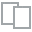
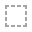
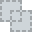
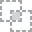
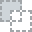
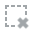
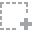
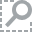
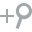
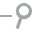
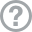
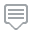
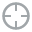
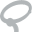
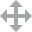
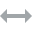
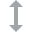
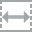
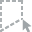
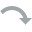
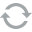
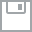
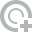
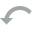
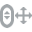
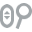
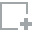
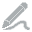
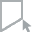
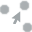
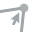
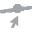

In [92]:
plot(df.drop(columns=["geometry"]))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4615 entries, 0 to 4614
Data columns (total 12 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   from_latitude                                                          4615 non-null   float64
 1   from_longitude                                                         4615 non-null   float64
 2   to_latitude                                                            4615 non-null   float64
 3   to_longitude                                                           4615 non-null   float64
 4   location_length                                                        4615 non-null   float64
 5   traffic_item_detail_incident_congestion_incident_congestion_type_desc  4615 non-null   object 
 6   traffic_item_detail_incident_congestion_incident_congestion_factor     4615 non-null   i

In [18]:
df = clean_df(df,report=False)[1]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4615 entries, 0 to 4614
Data columns (total 12 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   from_latitude                                                          4615 non-null   Float32
 1   from_longitude                                                         4615 non-null   Float32
 2   to_latitude                                                            4615 non-null   Float32
 3   to_longitude                                                           4615 non-null   Float32
 4   location_length                                                        4615 non-null   Float32
 5   traffic_item_detail_incident_congestion_incident_congestion_type_desc  4615 non-null   string 
 6   traffic_item_detail_incident_congestion_incident_congestion_factor     4615 non-null   I

In [112]:
from folium.plugins import HeatMapWithTime,HeatMap
import folium

# def generate_time_heatmap(
#     df, lat_col="from_latitude", lon_col="from_longitude", time_col="start_time"
# ):
#     df = df.rename(columns={lat_col: "lat", lon_col: "lon"})
#     data = []
#     for i in df[time_col].unique():
#         temp=[]
#         for index, instance in df[df['start_time'] == i].iterrows():
#             temp.append([instance['lat'],instance['lon']])
#         data.append(temp)
#     time_index = []
#     for i in df[time_col].unique():
#         time_index.append(i)
#     date_strings = [str(d) for d in time_index]
#     m = folium.Map([50, 11], tiles="cartodbpositron", zoom_start=8)
#     HeatMapWithTime(data, index=date_strings, radius=10,auto_play=True,position='bottomright').add_to(m)
#     return m
def generate_time_heatmap(
    df, lat_col="from_latitude", lon_col="from_longitude", time_col="start_time", interval="1H"
):
    df = df.rename(columns={lat_col: "lat", lon_col: "lon"})
    df = df.set_index(time_col)
    data = []
    time_index = []
    for key, d in df.resample(pd.Timedelta(interval)):
        data.append([[row['lat'], row['lon']] for _, row in d.iterrows()])
        time_index.append(str(key))
    # date_strings = [str(d) for d in time_index]
    m = folium.Map([50, 11], tiles="cartodbpositron", zoom_start=8)
    HeatMapWithTime(data, index=time_index, radius=15,auto_play=True,position='bottomright').add_to(m)
    return m


m = generate_time_heatmap(df.rename(columns={"from_latitude": "lat", "from_longitude": "lon"})
)

In [113]:
m